# Set-up code

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "/content/drive/MyDrive/CIS 583/Deep Learning project"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['archive', 'before_splitting', 'data', 'part2_fine-tuning_models_snapshots', 'part2_fine_tuning.ipynb', 'feature_extraction', 'part1_split_and_feature_extract(not_for_run).ipynb', 'submission', 'test_images', 'extra-version3_resnet50_fc_layer4_layer3_tuned_kritika_data_5classes_1channel-images.pth', 'little_test.ipynb']


In [ ]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
from torchvision import transforms, models
from PIL import Image
import os
import torch.nn as nn


# Fine-tuning of ResNet-50 based on 1-channel grayscaled images with unfreezing of the next combination of layers: {FC classifier + bottleneck 4, 3} (I used GPU in Google Collab to run this code)

- **What I do ('transfer learning')**:
  - fine-tuning for several first layers (✓)
  - behind the scene, I deepened the number of tuned layers to find the optimal trade-off between the accuracy and computational load (✓)
    - After trials and errors, I found out that this very combination of unfrozen layers leads to the most significant improve in accuracy. Any further unfereezing just slightly imrpove it but increase the amount of computations needed.

- **A couple of note**:
  - I will be using ResNet-50 (✓)
  - For transfer learning, it's better to use small LR (e.g., alpha ~ 0.0001) (✓)
  - It's better to plot test&train loss during the training (✓)
  - Always keep the snapshot of a model that worked best on the test data (✓)
  - If we use step scheduled change of LR, it's better to update LR every 30 epoches (✓)
  - There is sense to do training on a pretty balanced set (✓)
  - Increase regularization, when face the overfitting (✓)

  ## **Model training and validation description**:
- **General**:
  - **loss function: CrossEntropyLoss** (since our problem is classification);
  - **optimization algorithm: Adam** (common and effective optimization method that lets you use an adaptive LR);
  - **learning rate (LR) for FC: 1e-3** (we pick pretty high LR compared to those for depper layers but still smaller than one that is common for regular training, since we do fine-tuning, not training);
  - **learning rate (LR) for bottlenecks: 1e-4** (one magnitude smaller than for FC to avoid breaking the initial weights);  
  - **LR scheduler: ReduceLROnPlateau** (a common scheduler for fine-tuning cases);
  - **LR scheduler patience: 8** (based on trials and errors);
  - **Weight decay for FC: 1e-1** (L2 regularization measure);
  - **Weight decay for bottlenecks: 1e-2** (L2 regularization measure, less than one for FC since LR are smaller as well);
  - **early stopping patience: 18** (LR scheduler patience * 2 + 2).

- **Data**:
  - things related to data prep: see in part 1;

- **Data Loaders**:
  - **batch size for training: 10** (after trials with size = 4, 8, 16, 32, 64, 128, 256; we found that size =4 takes too much time to learn, whereas size bigger than ~8 faces overfitting. So, we picked batch = 10 as a measure of regularization).
  - **batch size for testing: 64** (since it doesn't affect anything, we decided to pick just a big size);
  - **shuffle for training: True** (to make sure that our model doesn't learn an order);
  - **shuffle for testing: False** (to make sure we have a consisnet test performance result).

- **Performace metrics**:
  - **test accuracy** (to track the performance over epoches by calculating how many images were predicted correctly at an epoch);
  - **train loss** (to catch the overfitting by tracking the magnitude of loss over time for train and comparing it with test loss);
  - **test loss** (main measure, to undertnad the magnutide of loss on a test data. We strive to the minimum test loss);
  - **confusion matrix** (to make sure that our model predictions are not biased towards some emotions).

**Define the pathes to data**:

In [ ]:
#define pathes to train and test data - make sure you have your own path!
path_to_train_5classes = '/content/drive/MyDrive/CIS 583/Deep Learning project/data/train_test_5_classes/train'
path_to_test_5classes = '/content/drive/MyDrive/CIS 583/Deep Learning project/data/train_test_5_classes/test'

**Prepare the data transformations and data-loaders**:

In [ ]:
#Prepare the Data
#Prepare the data loaders.

import torch
from torchvision import models
import torch.nn as nn

# Assuming you have the same transformations and data loading code as before

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomResizedCrop(224),  # Crop the images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomResizedCrop(224, scale=(0.8, 1)),  # Random scaling/zooming
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

# Normalization for testing, without augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize the image to 224x224 pixels
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485],   # Normalize the tensor image
                         std=[0.229]),
])
# Apply these transforms respectively while loading your training and testing datasets


train_dataset = datasets.ImageFolder(root= path_to_train_5classes,
                                     transform=train_transform,
                                    )
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)  # Adjust batch_size based on performance


test_dataset = datasets.ImageFolder(root= path_to_test_5classes,
                                    transform=test_transform,
                                   )
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Adjust batch_size based on performance

In [ ]:
#use it if needed

# import torch
# import torchvision.models as models

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


**Modify the First Convolutional Layer**:

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Change the first convolution layer to accept 1 channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # make sure there is 1 channel as an input for conv layer

# If you have a specific task, modify the final fully connected layer (optional, depending on your number of classes)
num_ftrs = model.fc.in_features
num_classes = 5
model.fc = nn.Linear(num_ftrs, num_classes)  # Replace `num_classes` with your actual number of classes

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Now your model should be ready to accept grayscale images


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Unfreeze only those layers that are needed**:

In [ ]:
# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the entire layer4
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True

# Unfreeze the fully-connected layer (not necessary as it's already unfrozen by default)
for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.conv3.weight
layer3.0.bn3.weight
layer3.0.bn3.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer3.1.conv3.weight
layer3.1.bn3.weight
layer3.1.bn3.bias
layer3.2.conv1.weight
layer3.2.bn1.weight
layer3.2.bn1.bias
layer3.2.conv2.weight
layer3.2.bn2.weight
layer3.2.bn2.bias
layer3.2.conv3.weight
layer3.2.bn3.weight
layer3.2.bn3.bias
layer3.3.conv1.weight
layer3.3.bn1.weight
layer3.3.bn1.bias
layer3.3.conv2.weight
layer3.3.bn2.weight
layer3.3.bn2.bias
layer3.3.conv3.weight
layer3.3.bn3.weight
layer3.3.bn3.bias
layer3.4.conv1.weight
layer3.4.bn1.weight
layer3.4.bn1.bias
layer3.4.conv2.weight
layer3.4.bn2.weight
layer3.4.bn2.bias
layer3.4.conv3.weight
layer3.4.bn3.weight
layer3.4.bn3.bias
layer3.5.conv1.

**Define the loss function, the optimization algorithm, and the training parameters**:

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #I use it since our problem is classification

optimizer = optim.Adam([
    {'params': model.layer3.parameters(), 'lr': 1e-4, 'weight_decay': 1e-2}, # I use pretty small learning rate because I do a fine-tuning
    {'params': model.layer4.parameters(), 'lr': 1e-4, 'weight_decay': 1e-2}, #I use pretty high weight decay to avoid overfitting of my model
    {'params': model.fc.parameters(), 'lr': 1e-3, 'weight_decay': 1e-1} #I use higher LR and decay for FC layer because I train it from scratch unlike the rest of the NN
])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=8) #common approach - reduce LR when we have no improvement in a parameter that we define during the training


model.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Training and Testing**:

Using device: cuda
Epoch 1, Training Loss: 1.2885244030218859, Test Loss: 0.9299850672483444, Accuracy of the model on the test images: 64.90630323679727%
Model saved
Epoch 2, Training Loss: 0.987140262992973, Test Loss: 0.9637202054262162, Accuracy of the model on the test images: 66.6098807495741%
No improvement in test loss for 1 epoch(s).
Epoch 3, Training Loss: 0.8583053890456501, Test Loss: 0.8988879352807999, Accuracy of the model on the test images: 66.26916524701873%
Model saved
Epoch 4, Training Loss: 0.767443488805722, Test Loss: 0.8814346820116044, Accuracy of the model on the test images: 69.84667802385009%
Model saved
Epoch 5, Training Loss: 0.7637949457917458, Test Loss: 0.790638180077076, Accuracy of the model on the test images: 74.44633730834752%
Model saved
Epoch 6, Training Loss: 0.7284917520661639, Test Loss: 0.7320240050554275, Accuracy of the model on the test images: 74.78705281090289%
Model saved
Epoch 7, Training Loss: 0.6583849621506838, Test Loss: 0.86380239

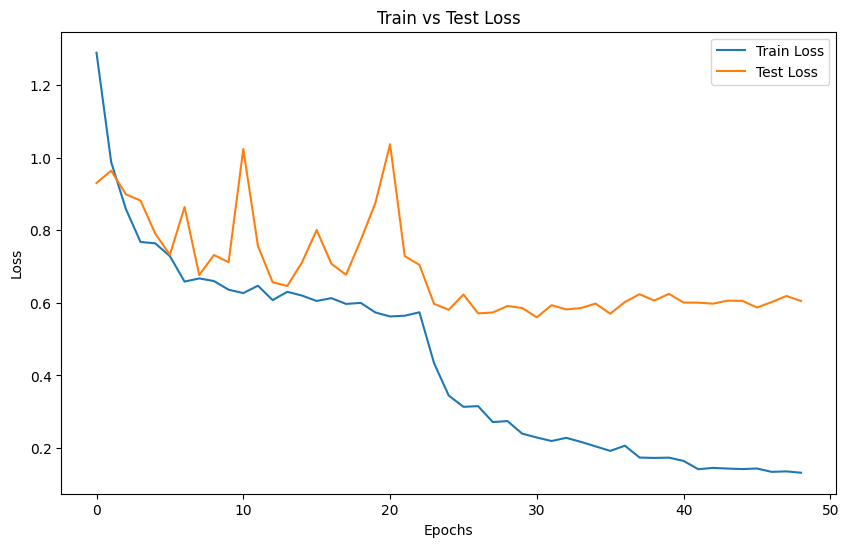

In [ ]:
import torch
import numpy as np

# Initialize Lists to Store Losses
train_losses = []
test_losses = []

# the Training Loop

# Assuming use of CPU; if using GPU, replace '.cpu()' with '.cuda()' where necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device (GPU or CPU)
model.to(device)

num_epochs = 100  # Specify the number of epochs

#patience = 15  # How many epochs to wait after last time test loss improved
patience = 18
best_test_loss = np.Inf  # Initialize the best test loss to infinity
patience_counter = 0  # Initialize the patience counter

for epoch in range(num_epochs):
    model.train()

    running_loss_train = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()

        # Directly use the classifier on features if using only the last layer
        outputs = model(features)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

        running_loss_train += train_loss.item()
    avg_train_loss = running_loss_train / len(train_loader)
    train_losses.append(avg_train_loss)


    # Evaluation Phase
    model.eval()
    running_loss_test = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)

            # Directly use the classifier on features
            outputs = model(features)
            val_loss = criterion(outputs, labels)

            # Get the predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss_test += val_loss.item()

    avg_test_loss = running_loss_test / len(test_loader)
    test_losses.append(avg_test_loss)
    # Calculate accuracy
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Accuracy of the model on the test images: {accuracy}%")

    # Step the scheduler with the average validation loss
    scheduler.step(avg_test_loss)

    # Early stopping logic
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        # Saving the model if test loss decreases
        torch.save(model.state_dict(), '/content/drive/MyDrive/CIS 583/Deep Learning project/extra-version3_resnet50_fc_layer4_layer3_tuned_kritika_data_5classes_1channel-images.pth')
        print('Model saved')
        patience_counter = 0  # Reset patience counter after improvement
    else:
        patience_counter += 1  # Increment patience counter if no improvement
        print(f"No improvement in test loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


# Plot Train and Test Losses
import matplotlib.pyplot as plt

# Plotting both the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

**Evaluation through counfusion matrix**:

Using device: cuda
Accuracy of the model on the test images: 82.793867120954%


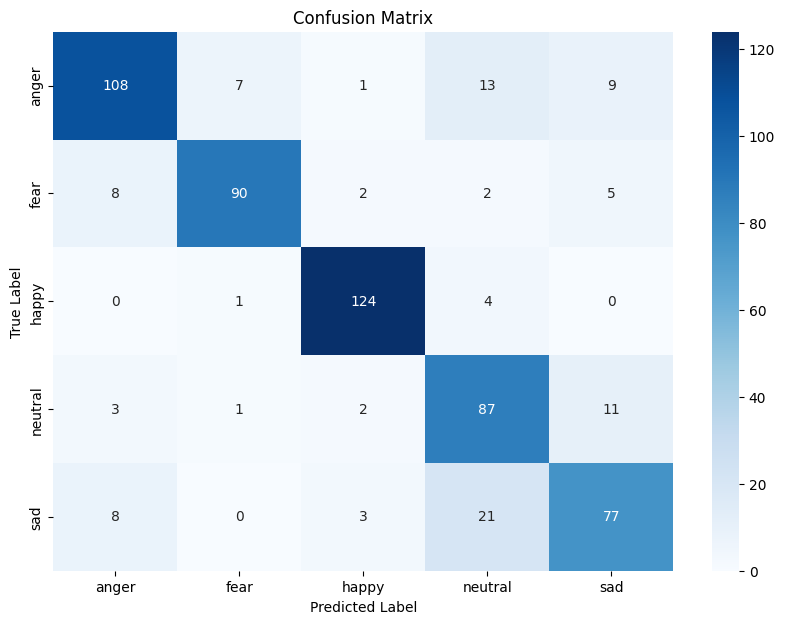

[[108   7   1  13   9]
 [  8  90   2   2   5]
 [  0   1 124   4   0]
 [  3   1   2  87  11]
 [  8   0   3  21  77]]


In [ ]:
#Evaluate the Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Move the model to the chosen device
model.to(device)

# Assuming you have a test_loader similar to train_loader
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No need to track gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

print(f'Accuracy of the model on the test images: {100 * correct / total}%')



from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a list of class names
class_names = ['anger', 'fear', 'happy', 'neutral', 'sad']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(cm)

- ## **Results of fine-tunning: 5 classes, FC+block 4,3: test_loss ~ 0.5, accuracy ~ 82%**
  - We see, that the most significant improve in accuracy and test_loss we get from unfrezzeing the combination of FL + bottleneck 4,3. Unfreezing deeper does improve the accuracy, however it would require more computational loads;


- ## **Takeaway**:
  - We have found an efficient combination of layers that brings pretty decent accuracy and test_loss and doesn't require much computations yet. However, since we know that gradual unfreezing more layers doesn't worsen the perfonce and can even improve it if we can afford more computational loads.

# Let's see how the model performs on manually selected photos

In [ ]:
# Define  a transformation pipeline once again to make sure
transform = transforms.Compose([
    #transforms.Resize((224, 224)),       # Resize the image to 224x224 pixels
    transforms.Resize((270, 270)),        #this ratio of sizes leads to better accuracy results, as I found
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485],   # Normalize the tensor image
                         std=[0.229])
])

In [ ]:
# Assuming your model architecture
model = models.resnet50(pretrained=False)  # Make sure the model architecture matches exactly what you used during training
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
num_classes = 5
model.fc = torch.nn.Linear(num_ftrs, num_classes)  # Replace num_classes with the actual number of classes you have

# Load the trained model weights
model_path = '/content/drive/MyDrive/CIS 583/Deep Learning project/extra-version3_resnet50_fc_layer4_layer3_tuned_kritika_data_5classes_1channel-images.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Assuming you're using CPU
device = torch.device('cpu')#'cuda')
model.to(device)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

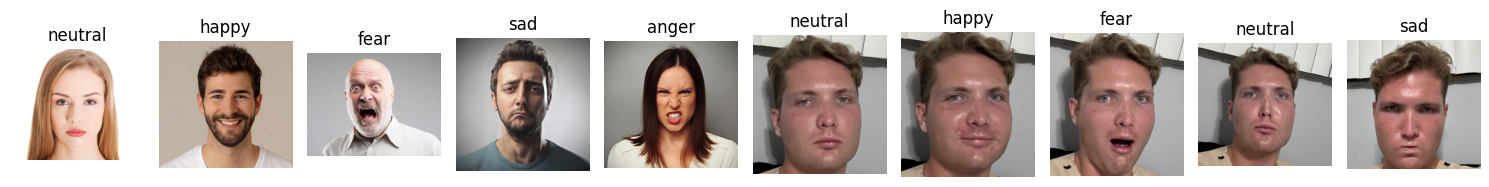

In [ ]:
#let's try our model on a set of test images

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'model' is your pretrained and loaded model, already set to evaluation mode
device = torch.device('cpu')
model.to(device)

# List of image paths
image_paths = ['/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/neutral.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/happy.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/fear.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/sad.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/anger.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/neutral2.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/happy2.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/fear2.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/sad2.jpeg',
               '/content/drive/MyDrive/CIS 583/Deep Learning project/test_images/anger2.jpeg']

class_names = ['anger', 'fear', 'happy', 'neutral', 'sad']

# Load each image, transform, predict, and display
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 3))  # Adjust the size as needed
axes = axes.flatten()

for i, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert('RGB')  # Open and convert to RGB just in case
    image_tensor = transform(image).unsqueeze(0).to(device)  # Apply transformation and add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]  # Assuming class_names is defined

    # Display the image with the prediction
    axes[i].imshow(image.convert("RGB"))  # Convert back to RGB to display
    axes[i].set_title(predicted_class)
    axes[i].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()
